<a href="https://colab.research.google.com/github/leoliuuu/PokerCardClassification/blob/main/PokerCards_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poker Card Classification with CNNs
Richard Gao & Leo Liu

## Installing Dependencies and Dataset

In [ ]:
!pip install torchviz
import gdown, os, shutil
from collections import defaultdict
from torchvision import models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import time, random, math, numpy as np # we always love numpy
import copy

     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=2bd7d36e297749d28db0bd27267ce74de48fb1b61d8955428cfeee3cdaced480
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


Download the playing card dataset

In [ ]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1kWLhxjrjkQt8gOmsP63NgnFC2Vgna9mw&export=download', 'playing_cards_master.zip', quiet=False)
!unzip -qq playing_cards_master.zip

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1kWLhxjrjkQt8gOmsP63NgnFC2Vgna9mw&export=download
To: /content/playing_cards_master.zip
529MB [00:07, 68.4MB/s]


## Setting up Dataset for Classification

We split up the dataset into two directories containing classes for card suits and numbers independently. We follow the file directory structure specified for creating PyTorch `ImageFolder` objects with a root directory and one subdirectory for each class containing the repective images.

In [ ]:
source_path = './playing-cards-master/'
dest_path_s = './suits/' 
dest_path_n = './numbers/'

In [ ]:
if os.path.exists(source_path):
  cards = os.listdir(source_path)

  # Determine suit and number classes within img directory
  classes_s = set()
  classes_n = set()
  indexes_s = defaultdict(list)
  indexes_n = defaultdict(list)
  for idx, card in enumerate(cards):
    if '[' in card and ']' in card:
      start = card.find('[')
      end = card.find(']')
      c = card[start+1:end]
      # Add suit and number to respective sets and remember the card indexes
      suit, num = c[0], c[1]
      if num == '0': # Correctly label cards numbered 10
        num = '10'
      classes_s.add(suit)
      classes_n.add(num)
      indexes_s[suit].append(idx)
      indexes_n[num].append(idx)

  # Create suit directories
  os.mkdir(dest_path_s)
  for s in classes_s:
    if not os.path.exists(dest_path_s + s): 
      os.mkdir(dest_path_s + s)

  # Create number directories
  os.mkdir(dest_path_n)
  for n in classes_n:
    if not os.path.exists(dest_path_n + n): 
      os.mkdir(dest_path_n + n)

  # Move suit images to corresponding directory
  for key, values in indexes_s.items():
    for i in values:
      shutil.copy(source_path+'/'+cards[i], dest_path_s+key)

  # Move number images to corresponding directory
  for key, values in indexes_n.items():
    for i in values:
      shutil.copy(source_path +'/'+cards[i],dest_path_n+key)
  
  # Delete img directory
  shutil.rmtree(source_path)

## Data Cache

We use CachedDataset in place of ImageFolder to cache each image in memory after each transform so that training speed is magnitudes faster

In [ ]:
# Datasets must always subclass either Dataset (either directly or indirectly)
# Here, we use subclass the ImageFolder class.
class CachedDataset(ImageFolder):
  def __init__(self, root, move_to_GPU=False, transform=None, target_transform=None):
      """ The init method passes most arguments up to the `ImageFolder` class.

          The exception is the `move_to_GPU` input, which if set to true will
          move the returned data to CUDA and if false, will keep it on the CPU
      """
      # make sure to call the super class init method
      super(CachedDataset, self).__init__(root,
                                          transform=transform,
                                          target_transform=target_transform)
      self.total_time_loading = 0
      self.move_to_GPU = move_to_GPU
      # we'll cache the loaded tensors here
      self.tensor_cache = {}

  def __getitem__(self, index):
      """
      Args:
          index (int): Index
      Returns:
          tuple: (image, target) where target is index of the target class.
      """
      t_start = time.time()
      if int(index) in self.tensor_cache:
          self.total_time_loading += time.time() - t_start
          return self.tensor_cache[int(index)]

      inputs, target = super(CachedDataset, self).__getitem__(index)
      if self.move_to_GPU:
          self.tensor_cache[int(index)] = inputs.to('cuda'), target
      else:
          self.tensor_cache[int(index)] = inputs, target
      self.total_time_loading += time.time() - t_start
      return self.tensor_cache[int(index)]

Image dimensions for transforms

In [ ]:
size = 400
image_dims = [3, size, size]

In [ ]:
playing_cards_s = CachedDataset(root='./suits',transform=transforms.Compose([
  transforms.Resize(size+1),
  transforms.CenterCrop(size),
  transforms.ToTensor()
]))

In [ ]:
playing_cards_n = CachedDataset(root='./numbers',transform=transforms.Compose([
  transforms.Resize(size+1),
  transforms.CenterCrop(size),
  transforms.ToTensor()
]))

There are 208 total images in our dataset

In [ ]:
len(playing_cards_s)

208

There are 4 classes for each suit (club, diamond, heart, and spade), and 13 classes for each number (2-10 and J, Q, K, A)

In [ ]:
print(len(playing_cards_s.classes), len(playing_cards_n.classes))

4 13


## Visualizing our Dataset

In [ ]:
def show_image(img_tensor):
  # need to reorder the tensor dimensions to work properly with imshow
  plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
  plt.axis('off')
  plt.show()

Visualizing one card

Suit
Card class: C
Image shape: torch.Size([3, 400, 400])


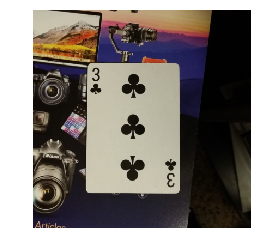

Number
Card class: 10


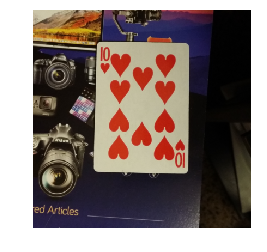

In [ ]:
print('Suit')
im, target = playing_cards_s[10]
print('Card class: ' + playing_cards_s.classes[target])
print('Image shape: ' + str(im.shape))
show_image(im)

print('Number')
im, target = playing_cards_n[10]
print('Card class: ' + playing_cards_n.classes[target])
show_image(im)

Visualizing a batch of cards

In [ ]:
def show_batch(images:CachedDataset, rows:int=5, figsize:tuple=(20,20)):
  fig, ax = plt.subplots(rows, rows, figsize=figsize)
  for i, im in enumerate(random.sample(range(len(images)), rows**2)):
      ax = plt.subplot(rows, rows, i+1)
      plt.title(images.classes[images[im][1]])
      plt.subplots_adjust(hspace=.2)
      ax.imshow(images[im][0].transpose(0,2).transpose(0,1))
      plt.axis('off')
      ax.set_axis_off()
  plt.show()

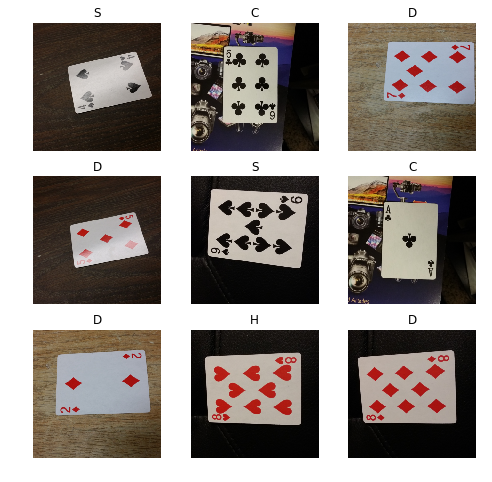

In [ ]:
show_batch(playing_cards_s, rows=3, figsize=(8,8))

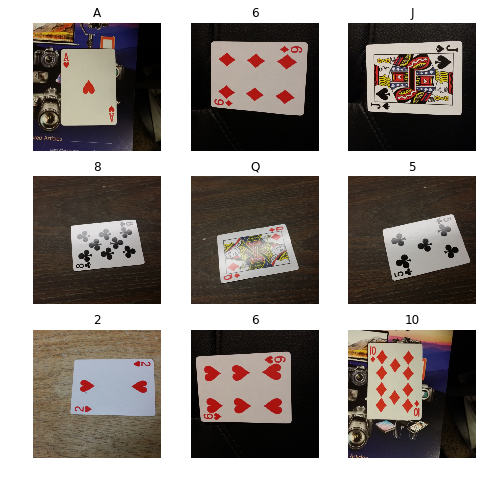

In [ ]:
show_batch(playing_cards_n, rows=3, figsize=(8,8))

## Training/Validation Dataset Split

We get the indicies for splitting the `playing_cards` dataset into a training set and a testing set. To do this we use a stratified split from `sklearn` so that we maintain a proportion of 75% of images into the training and 25% of images into the testing with at least one of each card.

In [ ]:
# https://discuss.pytorch.org/t/how-to-split-test-and-train-data-keeping-equal-proportions-of-each-class/21063/6
s = StratifiedShuffleSplit(n_splits=1, test_size=.25)
split_s = s.split(playing_cards_s.imgs, playing_cards_s.targets)
train_idx_s, test_idx_s = next(split_s)
split_n = s.split(playing_cards_n.imgs, playing_cards_n.targets)
train_idx_n, test_idx_n = next(split_n)

We create training and testing dataset subsets. We do this instead of using `SubsetRandomSampler` to pass into the `Dataloader` because we found doing so would not ensure deterministic results in the `test_loader` -> [example 1](https://github.com/pytorch/pytorch/issues/7209), [example 2](https://discuss.pytorch.org/t/dataloader-is-not-deterministic/19250), [example 3](https://github.com/pytorch/pytorch/issues/7068). What this means is that with a sampler everytime we used the test_loader, we would get a different order of images. We need to have a fixed and consistent testing set so that we can evaluate and determine when our model improves when tweaking hyper-parameters. Therefore we set a seed and use dataset subsets.


In [ ]:
train_set_s = Subset(playing_cards_s, train_idx_s)
test_set_s = Subset(playing_cards_s, test_idx_s)

train_set_n = Subset(playing_cards_n, train_idx_n)
test_set_n = Subset(playing_cards_n, test_idx_n)

# Define training parameters
batch_size = 32

# Get our data into the mini batch size that we defined
train_loader_s = torch.utils.data.DataLoader(train_set_s, batch_size=batch_size, shuffle=True)
test_loader_s = torch.utils.data.DataLoader(test_set_s)

train_loader_n = torch.utils.data.DataLoader(train_set_n, batch_size=batch_size, shuffle=True)
test_loader_n = torch.utils.data.DataLoader(test_set_n)

## Implementing Transfer Learning

## CNN Implementation

In [ ]:
class CNN(nn.Module):
  # The init funciton in Pytorch classes is used to keep track of the parameters of the model
  # specifically the ones we want to update with gradient descent + backprop
  # So we need to make sure we keep track of all of them here
  def __init__(self, classes):
      super(CNN, self).__init__()
      # layers defined here

      # Make sure you understand what this convolutional layer is doing.
      # E.g., considering looking at help(nn.Conv2D).  Draw a picture of what
      # this layer does to the data.

      # note: image_dims[0] will be 3 as there are 3 color channels (R, G, B)
      num_kernels = 16
      self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)

      # Make sure you understand what this MaxPool2D layer is doing.
      # E.g., considering looking at help(nn.MaxPool2d).  Draw a picture of
      # what this layer does to the data.

      self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

      # maxpool_output_size is the total amount of data coming out of that
      # layer.  We have an exercise that asks you to explain why the line of
      # code below computes this quantity.
      self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))

      # Add on a fully connected layer (like in our MLP)
      # fc stands for fully connected
      fc1_size = 64
      self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

      # we'll use this activation function internally in the network
      self.activation_func = torch.nn.ReLU()

      # Convert our fully connected layer into outputs that we can compare to the result
      fc2_size = len(classes)
      self.fc2 = nn.Linear(fc1_size, fc2_size)

      # Note: that the output will not represent the probability of the
      # output being in each class.  The loss function we will use
      # `CrossEntropyLoss` will take care of convering these values to
      # probabilities and then computing the log loss with respect to the
      # true label.  We could break this out into multiple steps, but it turns
      # out that the algorithm will be more numerically stable if we do it in
      # one go.  We have included a cell to show you the documentation for
      # `CrossEntropyLoss` if you'd like to check it out.
      
  # The forward function in the class defines the operations performed on a given input to the model
  # and returns the output of the model
  def forward(self, x):
      x = self.conv1(x)
      x = self.pool(x)
      x = self.activation_func(x)
      # this code flattens the output of the convolution, max pool,
      # activation sequence of steps into a vector
      x = x.view(-1, self.maxpool_output_size)
      x = self.fc1(x)
      x = self.activation_func(x)
      x = self.fc2(x)
      return x

  # The loss function (which we chose to include as a method of the class, but doesn't need to be)
  # returns the loss and optimizer used by the model
  def get_loss(self, learning_rate):
    # Loss function
    loss = nn.CrossEntropyLoss()
    # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
    optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    return loss, optimizer

In [ ]:
# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
suit_net = CNN(playing_cards_s.classes)
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
suit_net.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640000, out_features=64, bias=True)
  (activation_func): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {'train': train_loader, 'val': test_loader}

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=500, is_inception=(model_name=="inception"))

## Visualizing Network

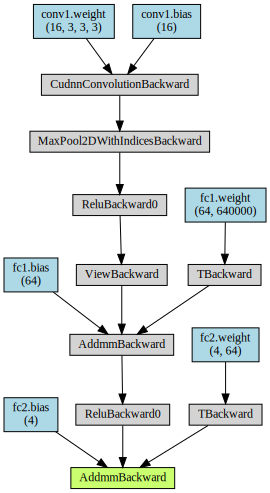

In [ ]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))

visualize_network(suit_net)

## Training

Set training parameters

In [ ]:
learning_rate = 1e-3
n_epochs = 20

In [ ]:
def train_model(net, train_loader, test_loader, learning_rate=1e-3, n_epochs=20):
  """ Train a the specified network.

      Outputs a tuple with the following four elements
      train_hist_x: the x-values (batch number) that the training set was 
          evaluated on.
      train_loss_hist: the loss values for the training set corresponding to
          the batch numbers returned in train_hist_x
      test_hist_x: the x-values (batch number) that the test set was 
          evaluated on.
      test_loss_hist: the loss values for the test set corresponding to
          the batch numbers returned in test_hist_x
  """ 
  loss, optimizer = net.get_loss(learning_rate)
  # Define some parameters to keep track of metrics
  print_every = 5
  idx = 0
  train_hist_x = []
  train_loss_hist = []
  test_hist_x = []
  test_loss_hist = []

  training_start_time = time.time()
  # Loop for n_epochs
  for epoch in range(n_epochs):
    
      running_loss = 0.0
      start_time = time.time()

      for i, data in enumerate(train_loader, 0):

          # Get inputs in right form
          inputs, labels = data
          inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
          
          # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
          optimizer.zero_grad()

          # Forward pass
          t_start = time.time()
          outputs = net(inputs)
          # print("forward time", time.time() - t_start)
          
          # Compute the loss and find the loss with respect to each parameter of the model
          loss_size = loss(outputs, labels)
          t_start = time.time()
          loss_size.backward()
          # print("backward time", time.time() - t_start)
          
          # Change each parameter with respect to the recently computed loss.
          optimizer.step()

          # Update statistics
          running_loss += loss_size.data.item()
          
          # Print every 20th batch of an epoch
          if (i % print_every) == print_every-1:
              print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                  epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
              # Reset running loss and time
              train_loss_hist.append(running_loss / print_every)
              train_hist_x.append(idx)
              running_loss = 0.0
              start_time = time.time()
          idx += 1

      # At the end of the epoch, do a pass on the test set
      total_test_loss = 0
      for inputs, labels in test_loader:

          # Wrap tensors in Variables
          inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

          # Forward pass
          test_outputs = net(inputs)
          test_loss_size = loss(test_outputs, labels)
          total_test_loss += test_loss_size.data.item()
      test_loss_hist.append(total_test_loss / len(test_loader))
      test_hist_x.append(idx)
      print("Validation loss = {:.2f}".format(
          total_test_loss / len(test_loader)))

  print("Training finished, took {:.2f}s".format(
      time.time() - training_start_time))
  return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

### Training Suit CNN

In [ ]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(suit_net, train_loader_s, test_loader_s)

Epoch 1, Iteration 5	 train_loss: 16.41 took: 33.54s
Validation loss = 12.03
Epoch 2, Iteration 5	 train_loss: 7.23 took: 0.73s
Validation loss = 3.48
Epoch 3, Iteration 5	 train_loss: 3.09 took: 0.65s
Validation loss = 2.14
Epoch 4, Iteration 5	 train_loss: 1.67 took: 0.65s
Validation loss = 1.94
Epoch 5, Iteration 5	 train_loss: 1.47 took: 0.65s
Validation loss = 1.18
Epoch 6, Iteration 5	 train_loss: 0.82 took: 0.65s
Validation loss = 1.03
Epoch 7, Iteration 5	 train_loss: 0.66 took: 0.66s
Validation loss = 1.03
Epoch 8, Iteration 5	 train_loss: 0.50 took: 0.66s
Validation loss = 0.99
Epoch 9, Iteration 5	 train_loss: 0.40 took: 0.66s
Validation loss = 0.96
Epoch 10, Iteration 5	 train_loss: 0.34 took: 0.66s
Validation loss = 0.86
Epoch 11, Iteration 5	 train_loss: 0.29 took: 0.66s
Validation loss = 0.92
Epoch 12, Iteration 5	 train_loss: 0.23 took: 0.66s
Validation loss = 0.92
Epoch 13, Iteration 5	 train_loss: 0.20 took: 0.66s
Validation loss = 0.89
Epoch 14, Iteration 5	 train_lo

Plotting training and validation loss

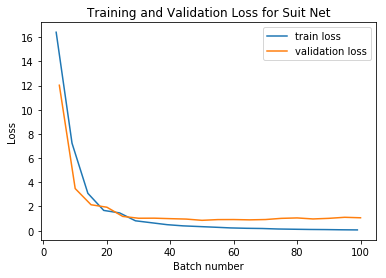

In [ ]:
plt.plot(train_hist_x, train_loss_hist)
plt.plot(test_hist_x, test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Suit Net')
plt.show()

### Training Number CNN

In [ ]:
num_net = CNN(playing_cards_n.classes)
num_net.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640000, out_features=64, bias=True)
  (activation_func): ReLU()
  (fc2): Linear(in_features=64, out_features=13, bias=True)
)

In [ ]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(num_net, train_loader_n, test_loader_n, learning_rate=1e-3, n_epochs=20)

Epoch 1, Iteration 5	 train_loss: 21.44 took: 34.13s
Validation loss = 10.93
Epoch 2, Iteration 5	 train_loss: 8.16 took: 0.70s
Validation loss = 4.37
Epoch 3, Iteration 5	 train_loss: 4.26 took: 0.65s
Validation loss = 3.16
Epoch 4, Iteration 5	 train_loss: 3.12 took: 0.65s
Validation loss = 2.96
Epoch 5, Iteration 5	 train_loss: 2.63 took: 0.65s
Validation loss = 2.58
Epoch 6, Iteration 5	 train_loss: 2.54 took: 0.66s
Validation loss = 2.57
Epoch 7, Iteration 5	 train_loss: 2.54 took: 0.65s
Validation loss = 2.60
Epoch 8, Iteration 5	 train_loss: 2.51 took: 0.65s
Validation loss = 2.63
Epoch 9, Iteration 5	 train_loss: 2.50 took: 0.65s
Validation loss = 2.61
Epoch 10, Iteration 5	 train_loss: 2.49 took: 0.65s
Validation loss = 2.63
Epoch 11, Iteration 5	 train_loss: 2.48 took: 0.65s
Validation loss = 2.61
Epoch 12, Iteration 5	 train_loss: 2.48 took: 0.65s
Validation loss = 2.65
Epoch 13, Iteration 5	 train_loss: 2.46 took: 0.65s
Validation loss = 2.63
Epoch 14, Iteration 5	 train_lo

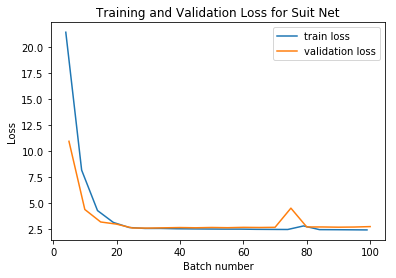

In [ ]:
plt.plot(train_hist_x, train_loss_hist)
plt.plot(test_hist_x, test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Suit Net')
plt.show()

## Interpretation

### Showing Model Predictions

In [ ]:
def disp_image(dataset, image, class_idx, predicted=None):
  # need to reorder the tensor dimensions to work properly with imshow
  plt.imshow(image.transpose(0,2).transpose(0,1))
  plt.axis('off')
  if not predicted is None:
      plt.title("Actual: " + dataset.classes[class_idx] + "     Predicted: " + dataset.classes[predicted])
  else:
      plt.title("Actual: " + dataset.classes[class_idx])
  plt.show()

In [ ]:
def test_model(dataset, net, idx):
  image, label = dataset[idx]
  class_scores = net(Variable(image.unsqueeze(0)).to(device))
  prediction = np.argmax(class_scores.cpu().detach().numpy())
  disp_image(dataset, image, label, prediction)

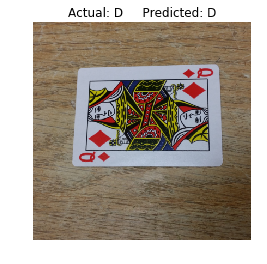

In [ ]:
test_model(playing_cards_s, model_ft, 100)
# test_model(playing_cards_n, num_net, 200)

### Computing accuracy of the model

In [ ]:
def get_accuracy(net, loader):
  n_correct = 0
  n_total = 0
  for i, data in enumerate(loader, 0):
      # Get inputs in right form
      inputs, labels = data
      inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

      # Forward pass
      outputs = net(inputs)
      n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
      n_total += labels.shape[0]
  return n_correct/n_total

Suit Net accuracy

In [ ]:
print("Train accuracy is", get_accuracy(model_ft, train_loader_s))
print("Test accuracy is", get_accuracy(model_ft, test_loader_s))

Train accuracy is 0.9871794871794872
Test accuracy is 0.9615384615384616


Number Net accuracy

In [ ]:
print("Train accuracy is", get_accuracy(num_net, train_loader_n))
print("Test accuracy is", get_accuracy(num_net, test_loader_n))

Train accuracy is 0.07692307692307693
Test accuracy is 0.07692307692307693


### Define interpretation functions

Get predictions of the model for interpretation

In [ ]:
import torch.nn.functional as F

# https://discuss.pytorch.org/t/efficient-method-to-gather-all-predictions/8008/5
def get_preds(model, test_loader):
  '''
  Make prediction from a pytorch model 
  '''
  # set model to evaluate model
  model.eval()
  
  y_true = torch.tensor([], dtype=torch.long, device=device)
  all_outputs = torch.tensor([], device=device)
  top_losses = []

  loss = nn.CrossEntropyLoss()
  img_idxes = test_loader.dataset.indices 
  
  # deactivate autograd engine and reduce memory usage and speed up computations
  with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        outputs = model(inputs)
        y_true = torch.cat((y_true, labels), 0)
        all_outputs = torch.cat((all_outputs, outputs), 0)
        # top_losses stores in a tuple the loss, img_idx w/ respect to playing_cards, and index that connects this loss value tothe other predictions
        top_losses.append((loss(outputs, labels).data.item(), img_idxes[i], i))
  
  y_true = y_true.cpu().numpy()  
  _, y_pred = torch.max(all_outputs, 1)
  y_pred = y_pred.cpu().numpy()
  y_pred_prob = [max(i) for i in F.softmax(all_outputs, dim=1).cpu().numpy()]
  top_losses.sort(reverse=True)
    
  return y_true, y_pred, y_pred_prob, top_losses

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.pyplot import figure

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          figsize=(15, 15)):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if not title:
      if normalize:
          title = 'Normalized confusion matrix'
      else:
          title = 'Confusion matrix, without normalization'

  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  # Only use the labels that appear in the data
  classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  #     print("Normalized confusion matrix")
  # else:
  #     print('Confusion matrix, without normalization')

  # print(cm)

  fig, ax = plt.subplots(figsize=figsize)
  # plt.rcParams['figure.figsize'] = [500, 500]
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          # ... and label them with the respective list entries
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel='Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  return ax

In [ ]:
def plot_top_losses(dataset, y_true, y_pred, y_pred_prob, top_losses, k=9, figsize=(12,12)):
  cols = math.ceil(math.sqrt(k))
  rows = math.ceil(k/cols)
  fig, ax = plt.subplots(cols, rows, figsize=figsize)
  fig.suptitle('Prediction/Actual/Loss/Probability', weight='bold', size=14)

  classes = dataset.classes

  top_losses = top_losses[:k]
  losses, img_idxes, pred_idxes = zip(*top_losses)

  for i in range(len(img_idxes)):
    pred_i = pred_idxes[i]

    ax = plt.subplot(cols, rows, i+1)
    plt.title(f'{classes[y_pred[pred_i]]} / {classes[y_true[pred_i]]} / {losses[i]:.2f} / {y_pred_prob[pred_i]:.2f}')
    ax.imshow(dataset[img_idxes[i]][0].transpose(0,2).transpose(0,1))
    plt.axis('off')
    ax.set_axis_off()

  plt.show()

### Visualizations

In [ ]:
y_true, y_pred, y_pred_prob, top_losses = get_preds(model_ft, test_loader_s)

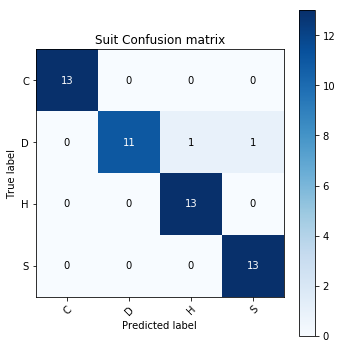

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=np.asarray(playing_cards_s.classes),
                      title='Suit Confusion matrix', figsize=(5,5))

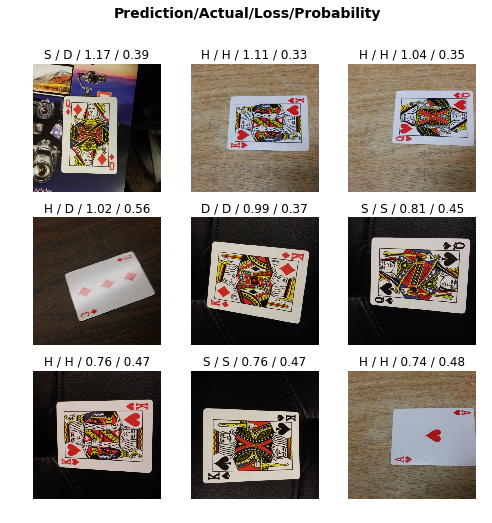

In [ ]:
plot_top_losses(playing_cards_s, y_true, y_pred, y_pred_prob, top_losses, figsize=(8,8))

In [ ]:
y_true, y_pred, y_pred_prob, top_losses = get_preds(num_net, test_loader_n)

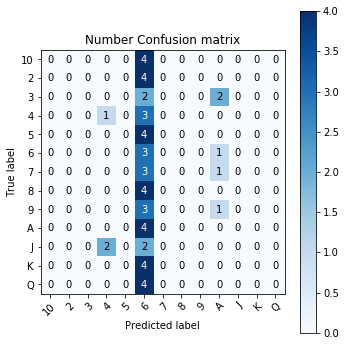

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=np.asarray(playing_cards_n.classes),
                      title='Number Confusion matrix', figsize=(5,5))

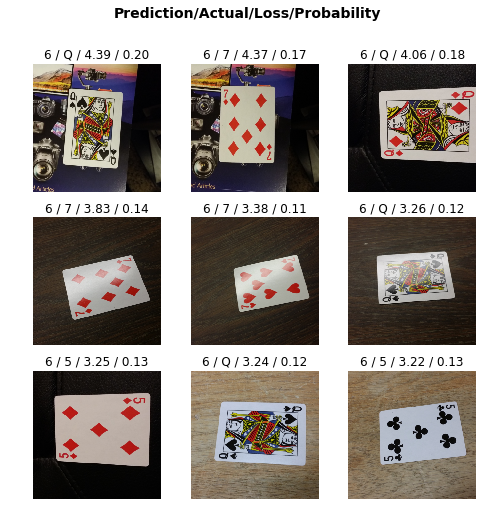

In [ ]:
plot_top_losses(playing_cards_n, y_true, y_pred, y_pred_prob, top_losses, figsize=(8,8))